In [383]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow

from vbpp.model import VBPP
from data_up_events_training import make_estimate_data_for_up

def build_data(user, start_line, end_line, filename):
    #events_oral = make_estimate_data(user,start_line,end_line,filename)
    #events = np.unique(events_oral.flatten())
    events = make_estimate_data_for_up(user, start_line, end_line, filename)
    num_observations = len(events)
    #print(num_observations)
    return events, num_observations

def domain_grid(domain, num_points):       #域grid
    return np.linspace(domain.min(axis=1), domain.max(axis=1), num_points)

def domain_area(domain):                   #域面积
    return np.prod(domain.max(axis=1) - domain.min(axis=1))

def build_model(events, domain, num_observations, M=20, variance = 1.0, lengthscales = 0.5 ):
    #kernel = gpflow.kernels.SquaredExponential()
    kernel = gpflow.kernels.SquaredExponential(variance = variance, lengthscales = lengthscales)
    Z = domain_grid(domain, M)                               #均匀切分domain,和events无关
    feature = gpflow.inducing_variables.InducingPoints(Z)    #inducing point（将均匀切分的点作为inducing point）
    q_mu = np.zeros(M)      #均值为0？
    q_S = np.eye(M)         #单位矩阵
    #print (events)
    num_events = len(events)
    beta0 = np.sqrt(num_events / domain_area(domain))       # 事件数/域面积 的开方,是什么？  是第二个模型的offset
    model = VBPP(feature, kernel, domain, q_mu, q_S, beta0=beta0, num_events=num_events, num_observations = num_observations)
    return model

In [915]:
N = 100     #预测点（lambda）
#目标用户信息,用于模型训练
object_user = 's052'
object_data_str = 0
object_data_end = 50

#kernel param
variance = 1.9
lengthscales = 0.53
inducing_num = 4

filename = "./data/DSL-StrongPasswordData.xls"
events,num_observations = build_data(object_user,object_data_str, object_data_end,filename)
events = np.array(events, float).reshape(-1, 1)

domain_max = max(events) + 0.03
domain = [0,domain_max]
domain = np.array(domain, float).reshape(1, 2)

model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

def objective_closure():                           #目标函数
    return - model.elbo(events)

gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

      fun: -263.6934927046058
 hess_inv: <21x21 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.90488682e+01,  2.15174982e-02, -1.91967175e+03,  1.15775597e+03,
       -1.34925545e+00, -1.60718022e+02, -7.22988409e+01,  5.75132117e+00,
       -4.25366554e+01, -2.95690221e+01,  5.75936463e+00, -2.03732618e+00,
        2.22490092e-01,  1.70120906e-01, -1.00940869e-01, -1.27764921e+00,
       -4.89838829e+01, -5.74426970e+00, -1.74218858e+01, -1.12484674e+01,
        1.89711480e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 66
      nit: 50
   status: 0
  success: True
        x: array([ 2.62572287e+01, -9.46072604e-01,  1.76440140e-02,  1.79739530e-01,
        1.07049054e+00, -1.49684312e+00,  3.09574595e+00,  1.80589749e+01,
       -2.75345384e+01, -2.74721681e+01,  1.80726399e+01,  4.58043189e-01,
        6.98211524e-01,  5.36151546e-01, -3.17498246e-01,  6.70566783e-01,
       -3.26761398e-01, -1.09812498e-01, -9.44337906e-02, -4.30837459e-

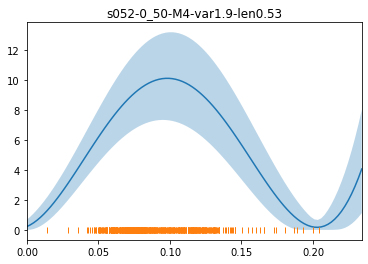

In [916]:
#画强度的估值图
X = domain_grid(domain, N)
lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
lower = lower.numpy().flatten()
upper = upper.numpy().flatten()

title = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales)

plt.title(title)
plt.xlim(X.min(), X.max())
#plt.ylim(0, 30)
plt.plot(X, lambda_mean)
plt.fill_between(X.flatten(), lower, upper, alpha=0.3)
plt.plot(events, np.zeros_like(events), '|')
plt.show()

In [917]:
#目标用户信息,用于模型训练
object_data_str = 50
object_data_end = 100

'''
#kernel param
variance = 1.9
lengthscales = 0.52
inducing_num = 4
'''

events,num_observations = build_data(object_user,object_data_str, object_data_end,filename)
events = np.array(events, float).reshape(-1, 1)

domain_max = max(events) + 0.03
domain = [0,domain_max]
domain = np.array(domain, float).reshape(1, 2)

model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

def objective_closure():                           #目标函数
    return - model.elbo(events)

gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

      fun: 115.19518887737479
 hess_inv: <21x21 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.66243968e+00,  1.46427773e+01, -1.56345637e+03,  1.66525066e+03,
       -3.82438017e+02, -1.54472400e+02, -1.51437662e+02,  8.38378665e+00,
       -2.52075104e-01, -2.70942726e+01,  9.24605323e+00, -1.78964553e+02,
        8.24736095e-01,  1.81583735e+00, -2.07996505e+00, -7.43878658e+00,
       -5.20331251e+01, -1.85940010e+02,  1.70389230e+02,  1.92607095e+02,
       -1.14233113e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 46
      nit: 30
   status: 0
  success: True
        x: array([ 2.99784649e+01, -4.65494147e-01,  3.04107196e-02,  1.58209965e-01,
        5.17754211e-01, -1.91801930e+00,  2.38261951e+00,  2.06430893e+01,
       -3.10194790e+01, -3.10153807e+01,  2.06494380e+01,  5.58762425e-03,
        1.16772125e+00,  1.07268015e+00, -8.10770910e-01,  1.35377315e-01,
       -4.38650583e-01, -1.38507826e+00,  9.81307428e-01,  9.96987035e-

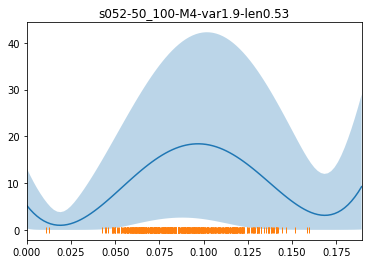

In [918]:
#画强度的估值图
X = domain_grid(domain, N)
lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
lower = lower.numpy().flatten()
upper = upper.numpy().flatten()

title = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales)

plt.title(title)
plt.xlim(X.min(), X.max())
#plt.ylim(0, 30)
plt.plot(X, lambda_mean)
plt.fill_between(X.flatten(), lower, upper, alpha=0.3)
plt.plot(events, np.zeros_like(events), '|')
plt.show()

In [920]:
#目标用户信息,用于模型训练
object_data_str = 100
object_data_end = 150


#kernel param
variance = 1.9
lengthscales = 0.53
inducing_num = 4


events,num_observations = build_data(object_user,object_data_str, object_data_end,filename)
events = np.array(events, float).reshape(-1, 1)

domain_max = max(events) + 0.03
domain = [0,domain_max]
domain = np.array(domain, float).reshape(1, 2)

model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

def objective_closure():                           #目标函数
    return - model.elbo(events)

gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

      fun: -95.44800599058851
 hess_inv: <21x21 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.48089064e+01,  1.18355069e+01, -3.03124006e+03, -9.55479433e+01,
       -2.77434941e+00,  1.17383209e+01, -1.73228282e+02,  9.30232742e+00,
       -4.77712863e+01, -1.28160465e+00,  9.25233827e+00, -1.58412368e+00,
        2.52344973e-01,  4.01551636e-01, -3.97429605e-01, -1.72065226e+00,
        2.76576718e-01, -1.13255858e+02,  1.07431383e+02,  7.95796241e+01,
       -4.19800252e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 53
      nit: 30
   status: 0
  success: True
        x: array([ 3.00407026e+01, -6.27563046e-01, -3.76159786e-03,  1.63042248e-01,
        8.18724735e-01, -1.47458374e+00,  2.15195115e+00,  2.09301946e+01,
       -3.09048976e+01, -3.09073505e+01,  2.09338883e+01,  5.47426993e-01,
        6.16704756e-01,  5.48728337e-01, -3.55176956e-01,  6.18614894e-01,
        7.87066384e-02, -7.41801146e-01,  4.40157594e-01,  4.94150148e-

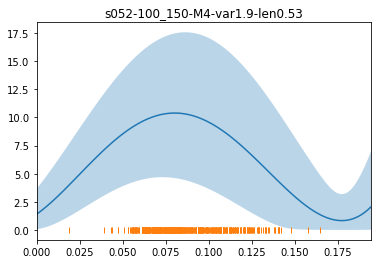

In [921]:
#画强度的估值图
X = domain_grid(domain, N)
lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
lower = lower.numpy().flatten()
upper = upper.numpy().flatten()

title = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales)

plt.title(title)
plt.xlim(X.min(), X.max())
#plt.ylim(0, 30)
plt.plot(X, lambda_mean)
plt.fill_between(X.flatten(), lower, upper, alpha=0.3)
plt.plot(events, np.zeros_like(events), '|')
plt.show()

In [922]:
#目标用户信息,用于模型训练
object_data_str = 150
object_data_end = 200

'''
#kernel param
variance = 1.0
lengthscales = 0.5
inducing_num = 3
'''

events,num_observations = build_data(object_user,object_data_str, object_data_end,filename)
events = np.array(events, float).reshape(-1, 1)

domain_max = max(events) + 0.03
domain = [0,domain_max]
domain = np.array(domain, float).reshape(1, 2)

model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

def objective_closure():                           #目标函数
    return - model.elbo(events)

gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

      fun: -17.78973547083706
 hess_inv: <21x21 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.67878778e+01, -7.83614577e+01,  1.55389079e+03, -1.37348310e+02,
        1.46742960e+02,  2.05702278e+02, -2.02443317e+02,  9.68571276e+00,
        4.64978576e+01,  1.11169991e+01,  9.22267979e+00, -1.78398757e+00,
        2.48932371e-01,  1.94080151e+00, -2.61006482e+00, -2.06701459e+00,
       -2.23233718e+01, -1.08851644e+02,  1.31044391e+02,  1.35249658e+02,
       -7.94373912e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 31
   status: 0
  success: True
        x: array([ 3.22294799e+01, -6.39341314e-01, -4.79394554e-03,  1.70116250e-01,
        6.78656531e-01, -1.48247514e+00,  2.09605589e+00,  2.19716704e+01,
       -3.23426430e+01, -3.23456138e+01,  2.19748148e+01,  4.93072285e-01,
        6.67419316e-01,  6.01465656e-01, -4.05256241e-01,  5.62757667e-01,
        3.83274275e-02, -8.47276063e-01,  5.58544821e-01,  6.08017552e-

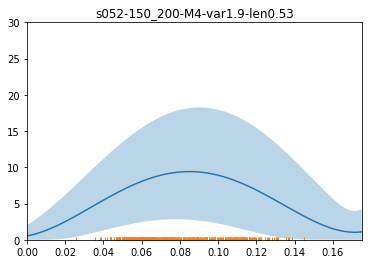

In [923]:
#画强度的估值图
X = domain_grid(domain, N)
lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
lower = lower.numpy().flatten()
upper = upper.numpy().flatten()

title = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales)

plt.title(title)
plt.xlim(X.min(), X.max())
plt.ylim(0, 30)
plt.plot(X, lambda_mean)
plt.fill_between(X.flatten(), lower, upper, alpha=0.3)
plt.plot(events, np.zeros_like(events), '|')
plt.show()

In [924]:
#目标用户信息,用于模型训练
object_data_str = 200
object_data_end = 250

'''
#kernel param
variance = 1.6
lengthscales = 0.5
inducing_num =3
'''

events,num_observations = build_data(object_user,object_data_str, object_data_end,filename)
events = np.array(events, float).reshape(-1, 1)

domain_max = max(events) + 0.03
domain = [0,domain_max]
domain = np.array(domain, float).reshape(1, 2)

model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

def objective_closure():                           #目标函数
    return - model.elbo(events)

gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

      fun: 1426.7240025101878
 hess_inv: <21x21 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.52894954e+02, -2.96398383e+03,  6.20136362e+04, -3.57874444e+04,
        1.60530885e+03,  3.37140204e+03, -4.67022166e+02, -4.52912409e+00,
        6.10948150e+02,  3.55306744e+02, -4.36070805e+00, -1.65716763e+00,
        5.10495541e-01,  5.08304258e+00, -5.76154654e+00, -9.42175937e+00,
       -3.44490352e+01, -9.11336012e+01,  1.11202476e+02,  9.47122379e+01,
       -9.26695571e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 28
      nit: 12
   status: 0
  success: True
        x: array([ 3.47303916e+01, -2.67821094e-01,  1.61599633e-02,  1.62635119e-01,
        5.12547117e-01, -1.19387542e+00,  1.94891518e+00,  2.24365579e+01,
       -3.25384802e+01, -3.25424356e+01,  2.24392058e+01,  4.73185897e-01,
        6.89844821e-01,  6.27332066e-01, -4.48177512e-01,  5.11646063e-01,
        2.95184744e-02, -8.73668701e-01,  6.25313371e-01,  6.83439496e-

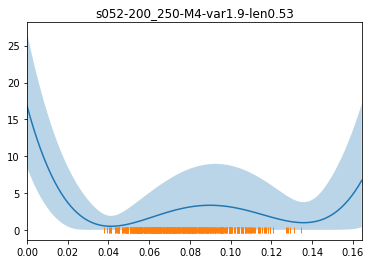

In [925]:
#画强度的估值图
X = domain_grid(domain, N)
lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
lower = lower.numpy().flatten()
upper = upper.numpy().flatten()

title = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales)

plt.title(title)
plt.xlim(X.min(), X.max())
#plt.ylim(0, 30)
plt.plot(X, lambda_mean)
plt.fill_between(X.flatten(), lower, upper, alpha=0.3)
plt.plot(events, np.zeros_like(events), '|')
plt.show()

In [926]:
#目标用户信息,用于模型训练
object_data_str = 250
object_data_end = 300

#kernel param
variance = 1.9
lengthscales = 0.51
inducing_num = 4

events,num_observations = build_data(object_user,object_data_str, object_data_end,filename)
events = np.array(events, float).reshape(-1, 1)

domain_max = max(events) + 0.03
domain = [0,domain_max]
domain = np.array(domain, float).reshape(1, 2)

model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

def objective_closure():                           #目标函数
    return - model.elbo(events)

gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

      fun: 76.85754175177237
 hess_inv: <21x21 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.80137297e-01,  3.20459258e+02, -3.22417909e+01,  6.95065288e+02,
       -1.79307173e+02,  4.99912152e+02, -2.30776442e+02,  1.16621171e+01,
        6.06649841e+00, -2.17135658e+01,  1.05028313e+01, -1.56608063e+00,
        9.25637489e-02,  2.27777352e+00, -3.12151576e+00, -5.16026754e+00,
       -2.81589486e+00, -8.47337654e+01,  1.04792697e+02,  1.08878360e+02,
       -5.01166606e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 36
   status: 0
  success: True
        x: array([ 3.04466716e+01, -6.01018387e-01, -5.79168042e-03,  1.87140699e-01,
        8.46223861e-01, -8.31067672e-01,  2.07149762e+00,  2.12406072e+01,
       -3.11223336e+01, -3.11252540e+01,  2.12444917e+01,  5.32602336e-01,
        6.21186211e-01,  5.37006059e-01, -3.51773794e-01,  6.20000255e-01,
        8.51846596e-02, -7.50120612e-01,  4.79306102e-01,  5.30834926e-0

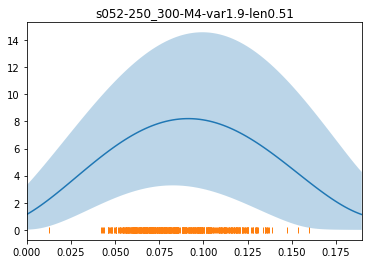

In [927]:
#画强度的估值图
X = domain_grid(domain, N)
lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
lower = lower.numpy().flatten()
upper = upper.numpy().flatten()

title = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales)

plt.title(title)
plt.xlim(X.min(), X.max())
#plt.ylim(0, 30)
plt.plot(X, lambda_mean)
plt.fill_between(X.flatten(), lower, upper, alpha=0.3)
plt.plot(events, np.zeros_like(events), '|')
plt.show()

In [928]:
#目标用户信息,用于模型训练
object_data_str = 300
object_data_end = 350

#kernel param
variance = 1.9
lengthscales = 0.53
inducing_num = 4

events,num_observations = build_data(object_user,object_data_str, object_data_end,filename)
events = np.array(events, float).reshape(-1, 1)

domain_max = max(events) + 0.03
domain = [0,domain_max]
domain = np.array(domain, float).reshape(1, 2)

model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

def objective_closure():                           #目标函数
    return - model.elbo(events)

gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

      fun: 99.14736336011049
 hess_inv: <21x21 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.16044856e+02,  2.56083991e+03, -9.44861332e+03,  2.75984632e+03,
       -7.38795073e+02,  2.99030649e+02, -2.23879716e+02,  2.16737340e+01,
       -1.05943689e+02, -4.60953191e+01,  1.25034007e+01, -1.20364661e+00,
       -9.65167527e-01,  4.10523001e+00, -5.38206820e+00, -1.30801313e+01,
        2.43089155e+01, -9.42198660e+01,  1.15726948e+02,  8.80787872e+01,
       -5.54792462e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 26
   status: 0
  success: True
        x: array([ 33.23623434,  -0.42157778,  -0.06338316,   0.20258866,
         0.67442038,  -1.44944654,   2.04408765,  20.52181203,
       -30.25745367, -30.25986713,  20.52376105,   0.60407557,
         0.54444212,   0.51592341,  -0.34501176,   0.63101134,
         0.21926583,  -0.76052687,   0.49996328,   0.5244288 ,
         0.22869361])

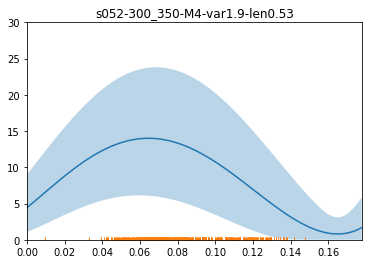

In [929]:
#画强度的估值图
X = domain_grid(domain, N)
lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
lower = lower.numpy().flatten()
upper = upper.numpy().flatten()

title = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales)

plt.title(title)
plt.xlim(X.min(), X.max())
plt.ylim(0, 30)
plt.plot(X, lambda_mean)
plt.fill_between(X.flatten(), lower, upper, alpha=0.3)
plt.plot(events, np.zeros_like(events), '|')
plt.show()

In [930]:
#目标用户信息,用于模型训练
object_data_str = 350
object_data_end = 400

#kernel param
variance = 1.9
lengthscales = 0.53
inducing_num = 4


events,num_observations = build_data(object_user,object_data_str, object_data_end,filename)
events = np.array(events, float).reshape(-1, 1)

domain_max = max(events) + 0.03
domain = [0,domain_max]
domain = np.array(domain, float).reshape(1, 2)

model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

def objective_closure():                           #目标函数
    return - model.elbo(events)

gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

      fun: 46.64206712088776
 hess_inv: <21x21 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.71807955e+01,  9.38860341e+01, -2.15704368e+03,  2.71059985e+03,
       -3.44189766e+02,  7.48986992e+01, -2.25534784e+02,  1.07657012e+01,
       -3.08442952e+01, -4.60033320e+01,  1.19035386e+01, -1.30390279e+00,
       -4.07889538e-01,  3.80274036e+00, -5.34046792e+00, -3.59305804e+00,
        1.11374776e+01, -9.20029684e+01,  1.18712824e+02,  1.02818792e+02,
       -6.10242298e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 66
      nit: 41
   status: 0
  success: True
        x: array([ 32.42643477,  -0.69951675,  -0.03957057,   0.19242054,
         0.74050854,  -1.18873514,   1.99236659,  21.74843959,
       -31.9887318 , -31.99047855,  21.75139062,   0.58195837,
         0.5799219 ,   0.54592342,  -0.36952398,   0.60570585,
         0.1554805 ,  -0.78298726,   0.5183644 ,   0.55390736,
         0.16626107])

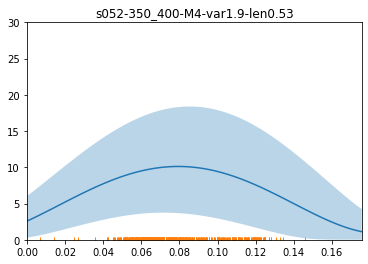

In [931]:
#画强度的估值图
X = domain_grid(domain, N)
lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
lower = lower.numpy().flatten()
upper = upper.numpy().flatten()

title = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales)

plt.title(title)
plt.xlim(X.min(), X.max())
plt.ylim(0, 30)
plt.plot(X, lambda_mean)
plt.fill_between(X.flatten(), lower, upper, alpha=0.3)
plt.plot(events, np.zeros_like(events), '|')
plt.show()